## ExperiWatt - Gehirn und Energie
In diesem Arbeitsblatt lernt ihr wie ihr eigenständig eine vollständige Bearbeitung, Visualisierung und Analyse von EEG Daten durchzuführt. Dafür haben wir das Energie-Experiment mit einer Testperson durchgefürt und für euch die aufgenommenen EEG Daten bereitgestellt. Das Energie-Experiment besteht aus zwei Teilen: den **passiven** und dem **aktiven** Teil. Im passiven Teil hat der Teilnehmer seine Augen still auf den Bildschirm gerichtet. Im zweiten Teil löst die Testperson konzentriert eine Matheaufgabe. 
<br><br>
**Wie sehen wir anhand der Gehirn Signale, dass die Testperson in einem Teil vom Experiment mehr oder weniger Energie verbraucht hat als im anderen Teil?** Diese Frage wollen wir heute beantworten!
<br><br>
Zum Analysieren benötigen wir einige Funktionen des Python Softwarepackages MNE die wir am Anfang importieren (siehe erste Code Zelle, die solltet ihr einmal mit Strg+Enter ausführen).
Die orangen "ToDo" Zellen geben an, wenn ihr den Code selber bearbeiten sollt. Drei `...` geben euch einen Tipp wo ihr eigene Werte einsetzen müsst. An der Punkteanzahl die ihr für jede Aufgabe bekommt könnt ihr den Schwierigkeitsgrad der Aufgabe abschätzen. Wichtig: Führt alle Code-Zellen aus (Str+Entr Tastenkombination), auch wenn kein "ToDo" darüber steht. 


Übersicht:
1) EEG Daten laden

2) Elektroden Montage Mapping 

3) Daten Betrachtung

4) Frequenz Power Spektrum

5) Preprocessing (Säubern der Daten)

6) Berechnung der Energie im aktiven und passiven Zustand

7) EEG Topography


In [ ]:
# zunächst importieren wir das MNE Package & weitere Packages, damit wir sie verwenden können
import logging
logging.getLogger('numexpr').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='.*FigureCanvasAgg is non-interactive.*')
import mne 
from mne import viz
from mne.io import RawArray
from mne.preprocessing import ICA
from mne_icalabel import label_components
from pyprep.find_noisy_channels import find_bad_by_ransac
import matplotlib.pyplot as plt
import numpy as np
from meegkit.detrend import detrend
from meegkit.dss import dss_line
import pandas as pd
from helper_functions import *
mne.set_log_level('ERROR')

### 1) EEG Daten laden
Um unsere Daten einsehen zu können müssen wir sie aus unserem Ordner wo wir sie gespeichert haben hier in unser Programm laden.

<div class='alert alert-warning'>
<b>ToDo</b> (1 Punkt): Ersetze die '...' durch den Namen der EEG Aufzeichnungsdatei. Verwendet hierfür den Namen 'Test_dataset2.vhdr'. Vergesst nicht die Endung '.vhdr' mitzunehmen. 
</div>

In [ ]:
# Name der Datei
fdir = 'Experiment/output_data/'
fname = '...'

# Lade die Datei. In MNE werden EEG Datensätze im "Raw" format gespeichert.
raw = mne.io.read_raw_brainvision(fdir+fname, preload=True)

### 2) Elektroden Montage Mapping
Das Softwarepackage MNE ermöglicht es uns mit einer standardisierten Map die EEG Aktivität auf die richtige Stelle auf dem Kopf zu projezieren. Die folgende Abbildung zeigt wie die Positionierung der Elektroden für das EEG System aussehen sollte. Diese Positionierung wird auch Montage genannt. Die Standardmontage die wir verwenden werden heißt `standard_1020`.
<br>
<br>

<div>
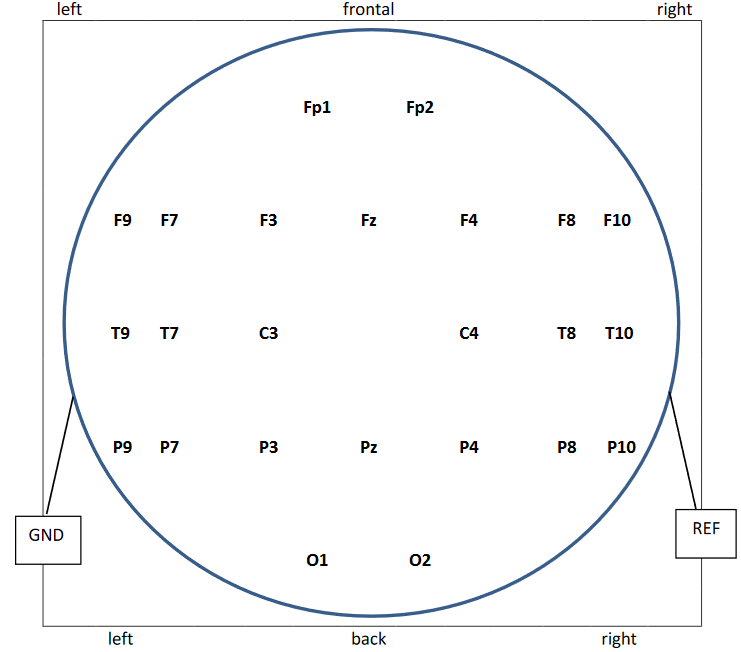
</div>

In [ ]:
# Standard Map laden und an Datensatz zufügen
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
fig = raw.plot_sensors(show_names=True)

In [ ]:
# Elektrodennummerierunge
channels = pd.read_csv('electrode_info.csv')
channels = channels[1:25].reset_index()['electrodes']
channel_names = pd.DataFrame(channels, index=range(24))
channel_names['ID'] = range(24)
channel_names

### 3) Daten Betrachtung
Jetzt können wir einen ersten Blick auf die Daten werfen!

<div class='alert alert-warning'>
    <b>ToDo</b> (2 Punkt): Erstelle eine Abbildung der EEG Daten. Verwende dazu die mne function <tt>plot_signal()</tt>, welche als Parameter das Datenset (<tt>raw</tt>), eine Startzeit und Endzeit (<tt>start</tt> und <tt>end</tt> in Sekunden), sowie Elektrodennummer(n) annimmt. 
    Beispiel:  <tt>plot_signal(raw, start=20, end=600, electrodes=[5, 21])</tt>. Betrachtet die ganze Länge der Daten, das Maximum für den Parameter "<tt>end</tt>" ist 600 Sekunden (10 Minuten). Findet heraus welche Elektrode(n) anders aussieht als andere, besonders auffällig ist oder ein ungewöhnliches Muster aufweist. Schreibt es in der Zeile unter der Abbildung die ihr generiert auf (in dem Platzhalter "..."). Kanäle mit schlechtem Signal werden wir in einem späteren Schritt entfernen. 
</div>

<div class='alert alert-success'>
    <b>Tipp</b>: Die Elektroden sind durchnummeriert. In der obigen Tabelle im Abschnitt "Elektroden Montage Mapping" könnt ihr sehen welche ID zu welcher Elektrode gehört. Diese könnt ihr dann fpr den Parameter <tt>electrodes</tt> in der Funktion <tt>plot_signal()</tt> eingeben. Beispiel: Um die Elektrode F4 und P3 darstellen zu lassen gebe ich die IDs 6 und 17 ein:
    <br><br>
    <tt>electrodes=[6, 17]</tt>
    <br><br>
    Mit dem Befehl <tt>range(24)</tt> (anstelle der eckigen Klammern) könnt ihr alle 24 Elektroden zugleich abbilden. Für 10 oder weniger Elektroden die ihr abbildet, wird eine Legende erstellt um die Elektroden identifizieren zu können.
</div>

In [ ]:
plot_signal(raw, start=..., end=..., electrodes=[...,...,...,...,...,...])

Notiert hier auffällige Elektrode(n): "..."

### 4) Frequenz Power Spektrum
EEG Daten sind aus Wellen verschiedener Frequenzen zusammengesetzt, da Neuronen in unserem Gehirn unterschiedlich schnelle Signale senden und miteinander kommunizieren. Jede Frequenz trägt unterschiedlich viel zur gesamten Leistung der Gehirnaktivität bei. Ihr habt bereits gelernt, dass die **Fourier Transformation** angewendet werden kann um die Amplitude jeder Frequenz des EEG Signals herauszufinden. Der resultierende Graph wird auch Power Spektrum genannt.

In diesem Aufgabenteil wollen wir herausfinden welche Frequenzen in unseren EEG Daten vorhanden sind, und wie stark jede Frequenz vertreten ist. 
Mit Hilfe der sogenannten Fourier Analyse ist es möglich die Amplituden jeder Frequenz des EEG Signals herauszufinden. Der resultierende Graph wird auch Power Spektrum genannt.

In der folgenden Abbildung seht ihr wie ein typisches EEG Spektrum von gereinigten Daten (und im Durchschnitt aller Elektroden) aussieht. Die y-Achse gibt mit $µV^2/Hz$ die Power der jeweiligen Frequenzen an. 


<div>
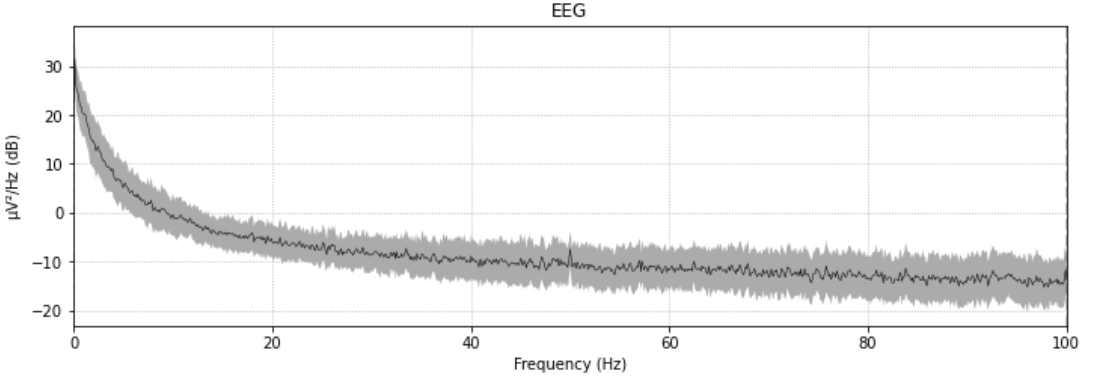
</div>


<div class='alert alert-warning'>
    <b>ToDo</b> (2 Punkte): Verwendet die <tt>plot_psd()</tt> Funktion (welche im Hintergrund die Fourier Transformation durchführt) um das Power Spektrum euer Daten zu berechnen, und gebt verschiedene Werte für "<tt>fmin</tt>" und "<tt>fmax</tt>" ein (niedrigste und höchste Frequenz). Gebt für den Parameter "<tt>fmax</tt>" maximal 100 Hz ein.
    Vergleicht euer Spektrum mit dem obigen Beispiel und beschreibt euer Ergebnis (die Abbildung) in der nächste Zeile, besonders wenn euch etwas ungewöhnliches auffällt. Denkt daran: das Spektrum in der Beispielabbildung ist ein Mittelwert aus allen 24 Kanälen.
</div>

Schreibt hier eure Beobachtungen auf: "..."

In [ ]:
raw.plot_psd(fmin=..., fmax=...)
plt.show()

### 5) Preprocessing
Die mit der EEG Kappe gemessene Aktivität ist leider nicht reine Gehirnaktivität. Da die Elektroden in der Kappe sehr sensitiv sind nehmen sie auch jede andere Veränderung von elektrischem Potenzial wahr. 
Wir werden die folgenden Rauschfaktoren Schritt für Schritt aus dem Signal entfernen:

5.1) Vorbereitungen

5.2) Baseline Correction

5.3) Kanäle mit schlechtem Signal

5.4) Stromleitungen

5.5) Augenblinzeln, Herzschlag und andere Muskelstörfaktoren

#### 5.1) Vorbereitungen

Führt erst ein Downsampling der Daten durch. Downsampling reduziert die Datenpunkte - dann geht das Bearbeiten schneller!

In [ ]:
resample_freq = 200
_ = raw.resample(resample_freq)

**WICHTIG**: Unser Energie-Experiment besteht aus zwei Teilen: dem **passiven Teil** in dem die Testperson den Blick auf das Kreuz fixiert hat, und dem **aktiven Teil** in dem die Testperson Zahlen zusammen addiert. Deshalb wird der Datensatz jetzt in diese beiden Abschnitte - Passiv und Aktiv - unterteilt, damit wir sie separat bearbeiten und später miteinander vergleichen können! Die Variablen die auf die jeweiligen Daten verweisen heißen ab jetzt ```raw_passive``` (für das passive Datenset) und ```raw_active``` (für das aktive Datenset).

In [ ]:
raw_passive, raw_active = split_dataset(raw)

#### 5.2) Baseline Correction
Manche Kanäle\Elektroden weisen durch Bewegung oder Zustand der Kopfhaut (e.g. durch Schwitzen) unterschiedliche Hintergrundaktivität auf, worduch die Signale auf unterschiedlichem Grundlevel liegen (auch baseline genannt). Wir wollen sie auf die selbe Baseline bringen. Verwende hierzu die Funktion `detrend_baselines()`.

Beispiel:

<div>
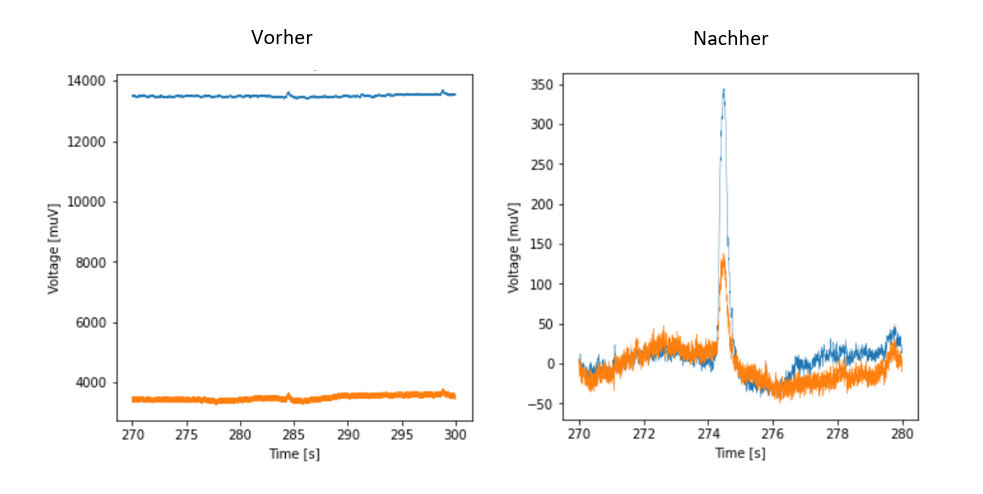
</div>



In [ ]:
# Verwende die Funktion "detrend_baselines()" um die Aktivität um die Baseline um die 0 mV zu bringen
detrend_baselines(raw_passive)
detrend_baselines(raw_active)

In [ ]:
# Schaue dir an wie die Daten nach dem Verschieben der Baseline aussehen
plot_signal(raw_passive, electrodes=[11,12,13,14])
plot_signal(raw_active, electrodes=[11,12,13,14])

<div class='alert alert-success'>
    <b>Tipp</b>: Die Signale aller Kanäle liegen nun alle ungefähr auf dem selben Level (um 0µV). Somit könnt ihr jetzt ganz einfach sehen ob es eine Elektrode gibt die sich stark über das Grundlevel hinaus bewegt/ein ungewöhnliches Signal aufweist. 
</div>

#### 5.3) Kanäle mit schlechtem Signal behandeln

Es ist möglich, dass einige Elektroden/Kanäle die Gehirnaktivität nicht richtig messen konnten und unbrauchbar sind - bei Trockenelektroden ist es normal, dass dies circa 20% der Kanäle sind. Wir müssen herausfinden welche Kanäle betroffen sind, um sie aus unserem Datenset zu entfernen. Dafür könnt ihr die Funktion `detect_bad_channels()` verwenden. Bei dieser Methode wird die Aktivität eines Kanals durch seine Nachbarkanäle vorhergesagt. Diese Vorhersage wird mit der echten Aktivität verglichen. Einen Kanal mit schlechtem Signal erkennt man daran, dass dieser auf Grund von vielen Störfaktoren nicht vorhergesagt werden kann.

In [ ]:
detect_bad_channels(raw_passive)
detect_bad_channels(raw_active)

<div class='alert alert-warning'>
    <b>ToDo</b> (3 Punkte): Lest ab welche Kanäle detektiert wurden und ergänzt sie dazu, was ihr schon in Abschnitt 3) notiert habt. Beim Aufnehmen des Datensatzes wurden außerdem die Elektroden 'P4', 'F8', 'T10', 'O1' und 'P7' als ungewöhnlich beurteilt. Diese, und alle Kanäle die ihr aufgeschrieben habt müssen unbedingt entfernt werden.
    <br><br>
    Gebt dafür dem Programm durch, um welche Kanäle es sich handelt. Fülle dazu die Liste mit den Punkten <tt>[..., ...]</tt> aus.
</div>

<div class='alert alert-success'>
    <b>Tipp</b>: Beispiel: <tt>bad_channels_passive = ['F7', 'P10']</tt> um Elektroden F7 um P10 zu entfernen. 
</div>

In [ ]:
bad_channels_passive = [..., ..., ..., ..., ..., ...]
bad_channels_active = [..., ..., ..., ..., ..., ...]

In [ ]:
# Entferne die Elektroden 
raw_passive_elect = remove_bad_channels(bad_channels_passive, raw_passive)
raw_active_elect = remove_bad_channels(bad_channels_active, raw_active)

In [ ]:
plot_signal(raw_passive_elect, start=10, end=12, electrodes=range(24))
plot_signal(raw_active_elect, start=10, end=12, electrodes=range(24))

#### 5.4) Störungen durch Stromleitungen
Beim Betrachten des Power Spektrums (siehe Abschnitt **4) Frequenz Power Spektrum**) ist euch sicher ein starke Spitze um 50Hz aufgefallen. Das sind die Wechselstromleitungen die von den EEG Elektroden aufgezeichnet werden. Damit wir dieses Signal loswerden können und dabei möglichst wenig der gemessenen Gehirnaktivität löschen, verwenden wir den sogenannten **ZapLine Algorithmus**. Dieser wurde in der Funktion `filter_line_power()` implementiert. "Line Power" ist der Englische Begriff für Stromleitungen.  

<div class='alert alert-warning'>
    <b>ToDo</b> (2 Punkte): Verwendet die Funktion <tt>filter_line_power()</tt>, um das Signal zu filtern. 
    Für den Parameter "<tt>line_freq</tt>", gebt die Frequenz der Wechselstromleitungen ein die entfernt werden soll. 
    <br/><br/>
    Passe außerdem den Parameter "<tt>filter_stärke</tt>" an, jenach Stärke des Störsignals. Je höher der Wert desto stärker die Filter-Wirkung (das Filter-Maximum ist 15). Ein zu starker Wert kann die Daten allerding verzerren.. findet also den passenden Wert indem ihr euch das Power Spektrum nach dem Filtern direkt anschaut und prüft ob das 50 Hz Artefakt nur noch wenig zu sehen ist und das Spektrum nicht verzerrt wird. 
</div> 

In [ ]:
# Verwende "dss_line()" für das "passive" Datenset ...
raw_passive_filtered = filter_line_power(raw_passive_elect, line_freq=..., filter_stärke=...)

# ... und für das "aktive"
raw_active_filtered = filter_line_power(raw_active_elect, line_freq=..., filter_stärke=...)

In [ ]:
# Kontrolliere das Ergebnis indem du das "neue" Power Spectrum plottest. Falls du noch einen Peak bei 50Hz siest, 
# erhöhe den Wert für "nremove" in der "dss_line()" Funktion
raw_passive_filtered.plot_psd(fmin=0, fmax=100)
plt.show()

raw_active_filtered.plot_psd(fmin=0, fmax=100)
plt.show()

#### 5.4) Augenblinzeln, Herzschlag und andere Muskelstörfaktoren
In diesem Abschnitt werden wir Störfaktoren wie Augenblinzeln und den Herzschlag aufspüren, wofür wir die sogenannte **Independent Component Analysis (ICA)** verwenden werden. Diese Analysemethode macht es möglich individuelle Störfaktoren die auf verschiedene Kanäle verteilt sind aufzuspüren.

In [ ]:
# Die Ausführung dieser Funktion kann etwas dauern 
raw_passive_cleaned = apply_ica(raw_passive_filtered)
raw_active_cleaned = apply_ica(raw_active_filtered)

Betrachtet die Daten noch einmal nach dem ihr die Preprocessing Schritte durchgeführt habt.

In [ ]:
plot_signal(raw_passive_cleaned, start=0, end=100, electrodes=range(24))
plot_signal(raw_active_cleaned, start=0, end=100, electrodes=range(24))

### 6) Berechnung der Energie im aktiven und passiven Zustand

Glückwunsch! Ihr habt eure Daten Erfolgreich gereinigt, sodass wir sie endlich für die Analyse verwenden können! 

Unser Ziel ist es, die **Energie** für das passive (auf das Fixierungskreuz fokussieren) und das aktive (Matheaufgabe lösen) Experiment vergleichen. Dafür brauchen wir das Power Spektrum, was ihr bereits im Abschnitt 4) bearbeitet habt. Für die Berechnung der Energie werden wir eine Funktion verwenden, die das Power Spektrum des jeweiligen Signals integriert. 


**WICHTIG**: Man unterteil das EEG Signal in verschiedene **Frequenz-Bänder**:
Die verschiedenen Frequenzbänder werden wie folgt unterteilt:


<div>
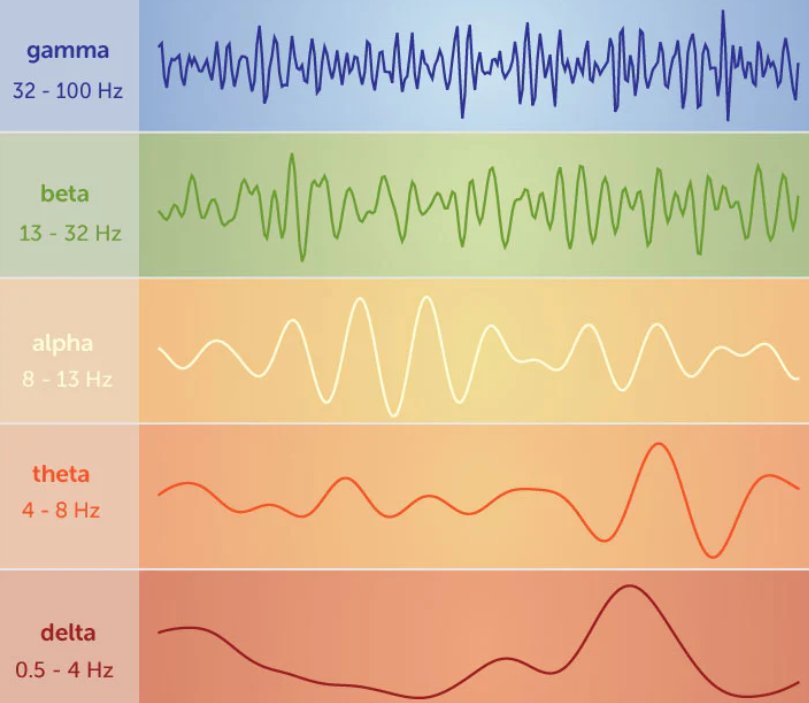
</div>


Diese Frequenz-Bänder sind im Gehirn in verschiedenen kognitiven Zuständen unterschiedlich ausgeprägt! 


- **Alpha-Band**: Stark ausgeprägt (hohe Power), wenn sich die gemessene Person in einem ruhenden Zustand befindet, keine Aufgabe hat oder sogar die Augen schließt.
- **Gamma-Band**: Ausgeprägt (hohe Power), wenn sich die gemessene Person konzentriert, zum Beipiel auf eine Aufgabe fokussiert ist. 


<div class='alert alert-warning'>
    <b>ToDo</b> (3 Punkte): Verwendet die Funktion <tt>compare_energy_plot()</tt> um die Energie der aktiven und passiven Session für das <b>Alpha-Band</b> und das <b>Gamma-Band</b> zu vergleichen. Schreibt in die nächste Zeile was für ein Ergebnis ihr erwartet, und ob eure Erwartungen mit eurem Ergebnis überein stimmen! 
</div> 

Schreibt hier:

Was für ein Ergebnis erwartet ihr? 
"..."

Stimmen eure Erwartungen mit eurem Ergebnis überein?
"..."

<div class='alert alert-success'>
    <b>Tipp</b>: Für das gesamte Frequenzspektrum würde ich es wie folgt eingeben: <tt>frequeny_band = [0,100]</tt>. Für das Alpha- und Gamma-Band müsst ihr also nur die Zahlen jeweils anpassen (siehe Abbilung)!
</div>

In [ ]:
# Vergleiche die Power im Alpha-Band
compare_energy_plot(raw_passive_cleaned, raw_active_cleaned, frequency_band=[..., ...])

In [ ]:
# Vergleiche die Power im Gamma-Band
compare_energy_plot(raw_passive_cleaned, raw_active_cleaned, frequency_band=[..., ...])

In [ ]:
# Power des gesamten Frequenzbereichs
compare_energy_plot(raw_passive_cleaned, raw_active_cleaned, frequency_band=[1, 50])

### 7) Topographie
Als letztes wollen wir uns anschauen wie die Frequenzen die wir uns im Power Spektrum (siehe Abschnitt **4) Frequenz Power Spektrum**) über das Gehirn verteilt sind. Die Elektroden sind so auf der EEG Kappe verteilt, dass sie verschiedene Bereiche des Gehirns messen können. Da wir im obigen Schritt (Abschnitt **Montage Mapping**) die Elektrodenposition bereits an die gemessenen Daten angeknüpft haben, können wir die Aktivität nun für die ganze EEG Kappe grafisch darstellen.



<div class='alert alert-warning'>
    <b>ToDo</b> (1 Punkt): Erstellt eine Topographie Abbildung des <b>Alpha-Frequenzbandes</b>. Diese Abbildung wird euch zeigen in welchen Teilen des Gehirns die Alpha-Frequenz am stärksten vorkommt.
</div> 

In [ ]:
frequency_band_topography(raw_passive_cleaned, frequency_band=[..., ...])